# Detection of Tip-Jets in CMIP6

The goal of this notebook is to present the methodology to detect Tip-Jets in CMIP6 simulations. In the first part of the notebook, we load and pre-process the data accessible directly on Google Servers. Second, we implement the detection methodology to detect Tip-Jets following the methodology developed by Vage et al. (2009) based on EOF decomposition of wind speed, temperature and sea level pressure.

**Ref:**
Våge, K., Spengler, T., Davies, H.C. and Pickart, R.S. (2009), Multi-event analysis of the westerly Greenland tip jet based upon 45 winters in ERA-40. Q.J.R. Meteorol. Soc., 135: 1999-2011. https://doi.org/10.1002/qj.488

https://rpickart.whoi.edu/wp-content/uploads/sites/53/2016/09/Vage-et-all-2009-muti-event-analysis.pdf

In [ ]:
# Install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 12.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=07d58dcdfbb2f50e3a06a21c38727dba91cdf813ad67051312386947105f0982
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=Shapely-1.8.5-cp310-cp310-linux_x86_64.whl size=832069 sha256=cc75117d87d8fa022b9aa317464d0787174

In [ ]:
# Import the classical libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr

# gcsfs to read data from online storage
import gcsfs

# sklearn for the EOF decomposition
from sklearn.decomposition import PCA

# mit to find consecutive numbers in a given list
import more_itertools as mit

# cartopy to plot geographical maps
import cartopy.crs as ccrs

# pyproj to compute clean distance between longitudes and latitudes
from pyproj import Geod
g = Geod(ellps='WGS84')

## Load and pre-process the data

In [ ]:
# load the dataset
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# find the zonal (x-direction) wind data to start
# This query can be understood as follow:
# activity_id is the type of CMIP experiment, the historical run are in the classical "CMIP" while the future scenarios are in "ScenarioMIP"
# table_id is generally the frequency of data spanning from hourly to yearly
# the experiment_id is genrally the type of forcing used for the runs, here "historical" is based on past observations
# variable_id is the quantity we want, "uas" means U-velocity (zonal) Atmopshere Surface
# the source is the model we want since many models reproduce the same experiments
# finally, we can select the member we want
df_uas = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='uas' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")

# setup the gcs access
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_uas.zstore.values[-1]

# create a mapping interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds_uas = xr.open_zarr(mapper, consolidated=True,decode_times=False).uas

In [ ]:
# Select data in our region for a quick look

lon_min, lon_max, lat_min, lat_max = 360-60, 360-25, 55, 65

mask = (ds_uas.lat>lat_min)&(ds_uas.lat<lat_max)&(ds_uas.lon>lon_min)&(ds_uas.lon<lon_max)

ds_area = ds_uas.where(mask, drop=True)

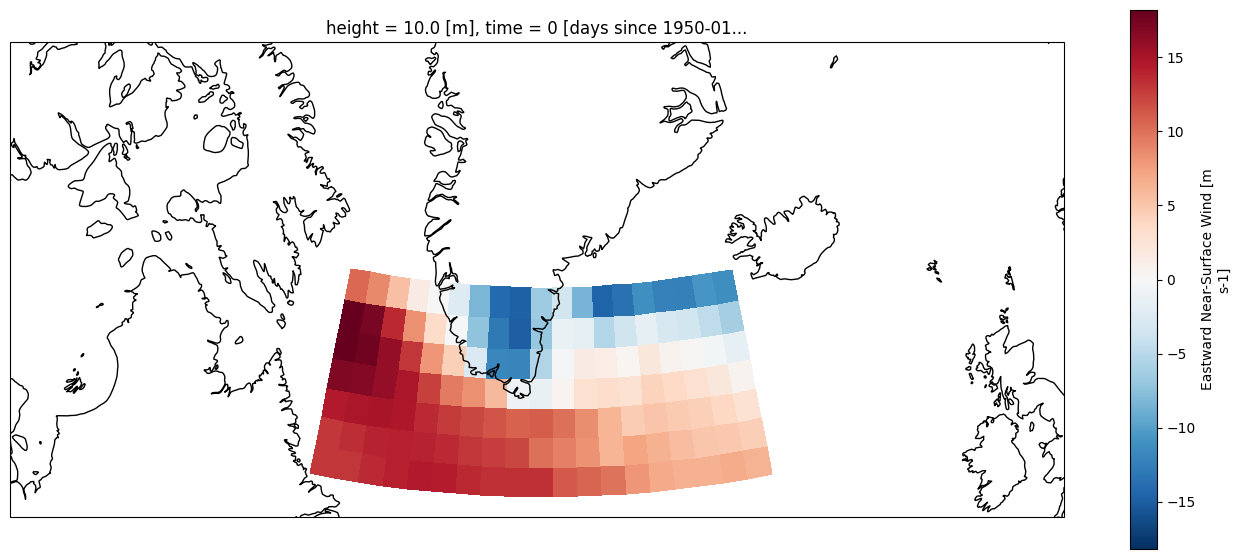

In [ ]:
# Plot

plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_area.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])

#### What data do we need for the detection ?

The map below present the required data. In the grey area, we will have to compute the point where the wind speed (both zonal and meridional components) **(variable_id=='sfcWind')** is maximum. At this location of maximum speed we will extract the surface temperature of the atmosphere **(variable_id=='tas')** and the zonal wind velocity **(variable_id=='uas')**.
Then, we want to compute the sea level pressure **(variable_id=='slp')** gradients along the three colored lines, for that we can just take the difference between the ends of each lines.

In [ ]:
lon_a, lat_a = 360+np.linspace(-47, -40, 20), np.linspace(60, 62, 20)
lon_b, lat_b = 360+np.linspace(-45, -40, 20), np.linspace(57, 62, 20)
lon_c, lat_c = 360+np.linspace(-40, -40, 20), np.linspace(56.5, 62, 20)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


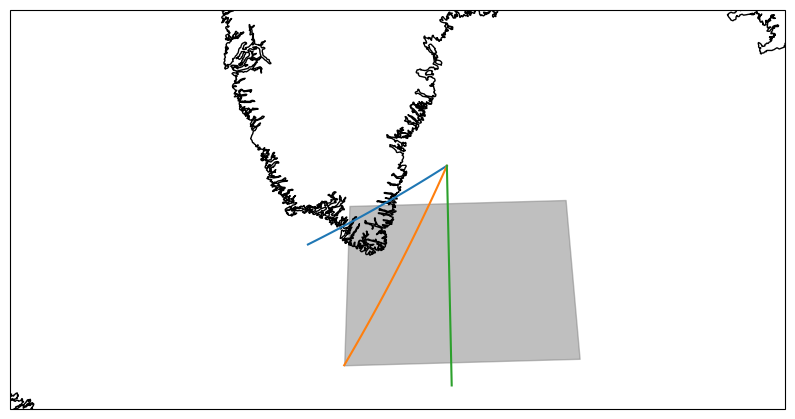

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))

ax.fill_between([-45, -34], 57, 61, color='grey', alpha=0.5, transform=ccrs.PlateCarree())

ax.plot(lon_a, lat_a, transform=ccrs.PlateCarree())
ax.plot(lon_b, lat_b, transform=ccrs.PlateCarree())
ax.plot(lon_c, lat_c, transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_extent([-60, -25, 55, 65])

### Extract uas from the grey area

In [ ]:
wind_area_u = ds_uas.where((ds_uas.lat>57)&(ds_uas.lat<61)&(ds_uas.lon>360-45)&(ds_uas.lon<360-34), drop=True)

### Load wind magnitude data

In [ ]:
df_mag = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='sfcWind' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")

zstore = df_mag.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_windmag = xr.open_zarr(mapper, consolidated=True,decode_times=False).sfcWind

In [ ]:
ds_windmag.lon.values, ds_uas.lon.values

(array([  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,  11.25 ,
         13.125,  15.   ,  16.875,  18.75 ,  20.625,  22.5  ,  24.375,
         26.25 ,  28.125,  30.   ,  31.875,  33.75 ,  35.625,  37.5  ,
         39.375,  41.25 ,  43.125,  45.   ,  46.875,  48.75 ,  50.625,
         52.5  ,  54.375,  56.25 ,  58.125,  60.   ,  61.875,  63.75 ,
         65.625,  67.5  ,  69.375,  71.25 ,  73.125,  75.   ,  76.875,
         78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,  90.   ,
         91.875,  93.75 ,  95.625,  97.5  ,  99.375, 101.25 , 103.125,
        105.   , 106.875, 108.75 , 110.625, 112.5  , 114.375, 116.25 ,
        118.125, 120.   , 121.875, 123.75 , 125.625, 127.5  , 129.375,
        131.25 , 133.125, 135.   , 136.875, 138.75 , 140.625, 142.5  ,
        144.375, 146.25 , 148.125, 150.   , 151.875, 153.75 , 155.625,
        157.5  , 159.375, 161.25 , 163.125, 165.   , 166.875, 168.75 ,
        170.625, 172.5  , 174.375, 176.25 , 178.125, 180.   , 181.875,
      

### Not so fast !

We always need to check and look at the data to avoid mistakes. As we can see in the above cell, the longitude axis for the u-wind and for the wind magnitude are different. This is due to the grid use in some models.

As you can see on the figure below, some models put their outputs in the C-grid they used for the computation instead of interpolating then into a A-grid. While in A-grid all data are located at the same locations, in a C-grid the zonal and meridional vectors are located at cell edges and the scalar data are located at the center of the cells.

To solve this issue, we can simply take a slighlty greater grid for the wing magnitude and re-interpolate linearly the data at the cell edges along the x-axis. As you can see on the schematic, the data are already colocated along the y-axis.

<img src="https://www.researchgate.net/publication/335242683/figure/fig2/AS:793660530630660@1566234824795/Arakawas-staggered-grids-Arakawa-and-Lamb-1977-a-A-grid-and-b-C-grid-In-the-C.ppm" style="height: 100px; width:100px;"/>

**Ref:** The Parcels v2.0 Lagrangian framework: new field interpolation schemes - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Arakawas-staggered-grids-Arakawa-and-Lamb-1977-a-A-grid-and-b-C-grid-In-the-C_fig2_335242683 [accessed 17 Jan, 2024][link text]

In [ ]:
# We select the area and the data since 1950
wind_mag_area= ds_windmag.where((ds_windmag.lat>57)&(ds_windmag.lat<61)&(ds_windmag.lon>360-46)&(ds_windmag.lon<360-33), drop=True).isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size))

# we convert the xr.Dataarray to np.array to make easy the processing
magnitude_np = wind_mag_area.values

# Linear interpolation along x
magnitude_at_u = # TODO ...

In [ ]:
# We can check that the interpolation bring us the right location

print('TODO -> ADD THE INTERPOLATED LONGITUDES FROM WIND MAGNITUDE DATASET')

print(wind_area_u.lon.values)

[315.9375 317.8125 319.6875 321.5625 323.4375 325.3125]
[315.9375 317.8125 319.6875 321.5625 323.4375 325.3125]


In [ ]:
# Now you must find the location of the maximum of wind magnitude for each time step

# TODO

# And do the same to extract uas at this maximum
u_at_max = # TODO

### Load and process temperature data

Now, we can do the same with temperature data (tas). It will be easier since it is already located at the cell center.

In [ ]:
# Load data

df_tas = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='tas' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")

zstore = df_tas.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_temp = xr.open_zarr(mapper, consolidated=True,decode_times=False).tas

In [ ]:
# Extract the grey area and the data after 1950

temp_area = ds_temp.where((ds_temp.lat>57)&(ds_temp.lat<61)&(ds_temp.lon>360-46)&(ds_temp.lon<360-33), drop=True).isel(time=np.arange(ds_temp.time.size-ds_uas.time.size, ds_temp.time.size))


In [ ]:
# Again find the location of the maximum for each time step (warning this time it is the same grid between original wind magnitude and temperature)

# Extract the temperature at these maximums

t_at_max = #TODO (Here we can remove -273.15 to convert the data into celsius degree but it is not mandatory)

In [ ]:
t_at_max

array([ 5.8844604, -3.1313477, -4.1494446, ...,  6.8258057,  3.940857 ,
        3.0080872], dtype=float32)

### Load Sea Level Pressure (SLP) data

In [ ]:
df_psl = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='psl' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")

In [ ]:
zstore = df_psl.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_slp = xr.open_zarr(mapper, consolidated=True,decode_times=False).psl

# select data after 1950
ds_slp = ds_slp.isel(time=np.arange(ds_slp.time.size-ds_uas.time.size, ds_slp.time.size))

Find the nearest node in the model data

In [ ]:
nearest_a_start = #TODO
nearest_a_end = #TODO
nearest_b_start = #TODO
nearest_b_end = #TODO
nearest_c_start = #TODO
nearest_c_end = #TODO

Check that the nearest node is not too far or in a wrong place (like on Greenland)

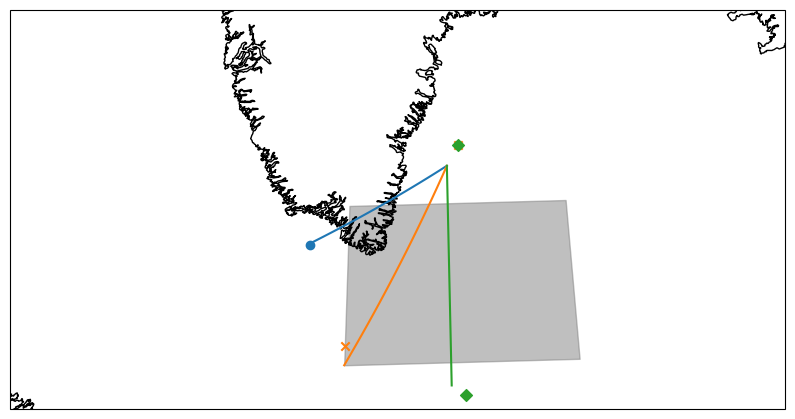

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))

ax.fill_between([-45, -34], 57, 61, color='grey', alpha=0.5, transform=ccrs.PlateCarree())

ax.plot(lon_a, lat_a, transform=ccrs.PlateCarree())
ax.plot(lon_b, lat_b, transform=ccrs.PlateCarree())
ax.plot(lon_c, lat_c, transform=ccrs.PlateCarree())

plt.scatter(nearest_a_start.lon.values, nearest_a_start.lat.values, transform=ccrs.PlateCarree(), c='tab:blue')
plt.scatter(nearest_a_end.lon.values, nearest_a_end.lat.values, transform=ccrs.PlateCarree(), c='tab:blue')
plt.scatter(nearest_b_start.lon.values, nearest_b_start.lat.values, transform=ccrs.PlateCarree(), c='tab:orange', marker='x')
plt.scatter(nearest_b_end.lon.values, nearest_b_end.lat.values, transform=ccrs.PlateCarree(), c='tab:orange', marker='x')
plt.scatter(nearest_c_start.lon.values, nearest_c_start.lat.values, transform=ccrs.PlateCarree(), c='tab:green', marker='D')
plt.scatter(nearest_c_end.lon.values, nearest_c_end.lat.values, transform=ccrs.PlateCarree(), c='tab:green', marker='D')
ax.coastlines()
ax.set_extent([-60, -25, 55, 65])

Compute the gradient using g.inv to find the distance between nodes

In [ ]:
grad_a = #TODO
grad_b = #TODO
grad_c = #TODO

## Detection of Tip-Jets with EOF from Vage et al. (2009)

### EOF computation

In [ ]:
# We build our data matrix on which we will compute the EOF. Their is 2 dimensions: samples (here the time) and the features (here u_at_max, t_at_max and the three slp gradient).
# We therefore want a matrix NxM with N the number of time steps and M=5

N, M = len(wind_area_u.time.values), 5
X = np.zeros((N, M))

X[:, 0] = #TODO
X[:, 1] = #TODO
X[:, 2] = #TODO
X[:, 3] = #TODO
X[:, 4] = #TODO

In [ ]:
# Use sklearn to compute PCA decompositions, here we only take the first component which is supposed to represent tip-jets

#TODO

In [ ]:
pca.explained_variance_ratio_

array([0.71672801])

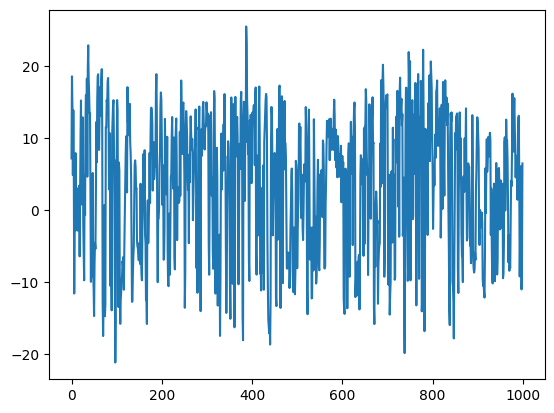

In [ ]:
# We can look at the u_at_max associated with this first component

comp = 0

EOF_wind_intensity =  pca.components_[comp, 0]*Xpca[:, comp] + pca.mean_[0]

plt.plot(EOF_wind_intensity[:1000])

In [ ]:
# Now we create a function to put together the tip-jet detected that are in the same event (with consecutive indices)

def consecutiveGroupes(indices):
    consec = []
    for group in mit.consecutive_groups(indices):
        consec.append(list(group))

    return np.array(consec, dtype='object')

In [ ]:
# We can define TJ as the 5% strongest winds, since the treshold proposed by Vage et al. is arbitrary and depend on the resolution of the dataset

print(np.percentile(EOF_wind_intensity, 95))

events = consecutiveGroupes(np.where(EOF_wind_intensity>np.percentile(EOF_wind_intensity, 95))[0])
len(events)

16.722212789682068


807

Now we want to check the consistency of the detected pattern. We will first look at the spatial pattern to see how it look like. Second, we will look at the frequency to see wether it matches the 586 events between 1957 and 2002 found by Vage et al.

In [ ]:
ds_windmag_compositeTJ = #TODO -> Compute a composite (an time-mean map) of wind magnitude during Tip-Jet events


The pattern is pretty close to the one described in the paper !

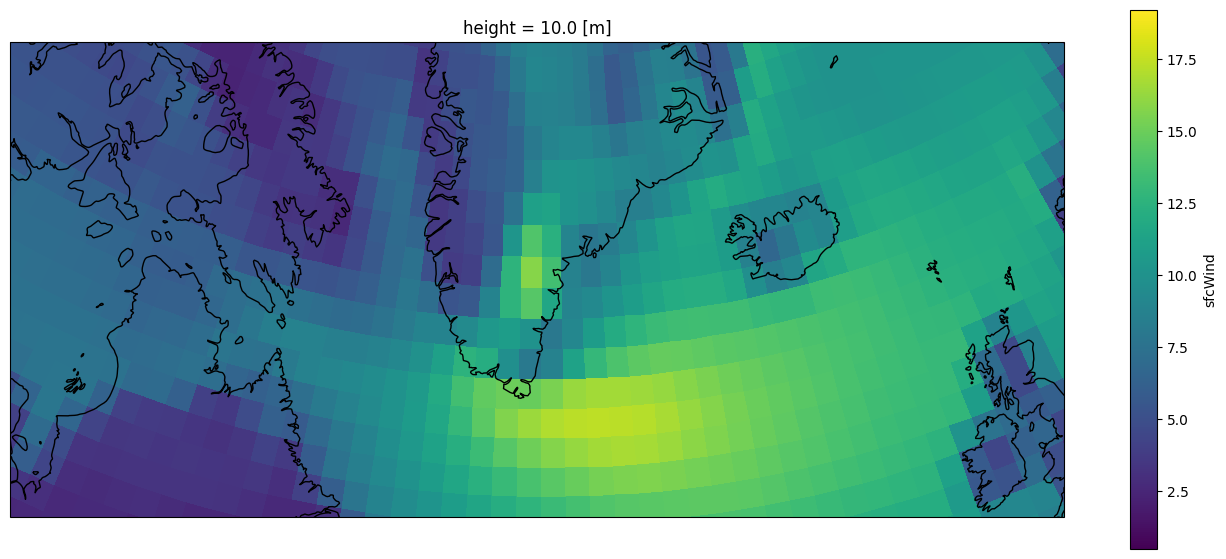

In [ ]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_windmag_compositeTJ.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])

In [ ]:
# the frequency match pretty well

len(events)/(2015-1950), 586/(2002-1957)

(12.415384615384616, 13.022222222222222)

We can now look at the evolution of frequency over time

In [ ]:
time_axis = np.arange(np.datetime64('1950-01-01 12:00'), np.datetime64('2015-01-01 12:00'), np.timedelta64(1, 'D'))

time_tip_jet_events = np.array([time_axis[int(np.mean(events[i]))] for i in range(len(events))])

time_axis_yearly = np.arange(np.datetime64('1950'), np.datetime64('2015'), np.timedelta64(1, 'Y'))

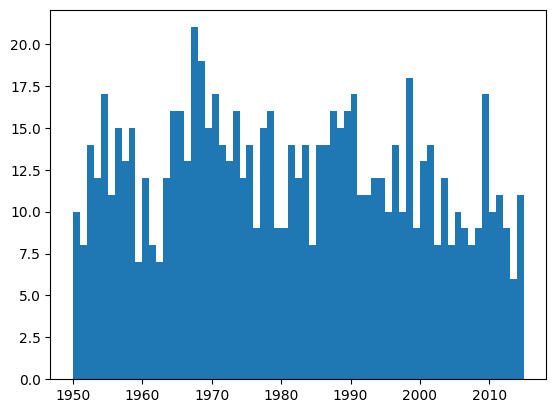

In [ ]:
histo_tip_jet = plt.hist(time_tip_jet_events, bins=65)

### You can now look at different models and members and for different scenarios of the 21st century !